# Dataset Info.

## 1. train.csv
ID : 실제 판매되고 있는 고유 ID<br>
제품 : 제품 코드<br>
대분류 : 제품의 대분류 코드<br>
중분류 : 제품의 중분류 코드<br>
소분류 : 제품의 소분류 코드<br>
브랜드 : 제품의 브랜드 코드<br>
2022-01-01 ~ 2023-04-04 : 실제 일별 판매량<br>
단, 제품이 동일하여도 판매되고 있는 고유 ID 별로 기재한 분류 정보가 상이할 수 있음<br>
즉 고유 ID가 다르다면, 제품이 같더라도 다른 판매 채널<br><br>


## 2. sample_submission.csv -제출 양식
ID : 실제 판매되고 있는 고유 ID<br>
						※ 제출 시 ID Column에 해당하는 데이터에 반드시 zfill(5)를 적용할 필요 없음<br>

2023-04-05 ~ 2023-04-25 : 예측한 일별 판매량<br>


## 3. sales.csv [파일] - 메타(Meta) 정보
ID : 실제 판매되고 있는 고유 ID<br>
제품 : 제품 코드<br>
대분류 : 제품의 대분류 코드<br>
중분류 : 제품의 중분류 코드<br>
소분류 : 제품의 소분류 코드<br>
브랜드 : 제품의 브랜드 코드<br>
2022-01-01 ~ 2023-04-04 : 실제 일별 총 판매금액<br>
단, 제품이 동일하여도 판매되고 있는 고유 ID 별로 기재한 분류 정보가 상이할 수 있음<br>
즉 고유 ID가 다르다면, 제품이 같더라도 다른 판매 채널<br><br>


## 4. brand_keyword_cnt.csv [파일] - 메타(Meta) 정보
브랜드 : 브랜드 코드<br>
2022-01-01 ~ 2023-04-04 : 브랜드의 연관키워드 언급량을 정규화한 일별 데이터<br><br>


## 5. product_info.csv [파일] - 메타(Meta) 정보
제품 : 제품 코드<br>
제품특성 : 제품 특성 데이터(Text)<br>
train.csv에 존재하는 모든 제품 코드가 포함되어 있지 않음. 또는 product_info.csv에 존재하는 제품 코드가 train.csv에 존재하지 않을 수 있음<br>


In [1]:
import os

files = os.listdir('.')
print(files)

['.ipynb_checkpoints', 'brand_keyword_cnt.csv', 'lgaimers_3_hackathon_dataset.ipynb', 'product_info.csv', 'sales.csv', 'sample_submission.csv', 'train.csv']


In [2]:
import random
import os
import pandas as pd 
import numpy as np
from tqdm.auto import tqdm
from sklearn.preprocessing import LabelEncoder

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

In [3]:
df = pd.read_csv('./train.csv')   # datetime 형태로
df.head()

,ID,제품,대분류,중분류,소분류,브랜드,2022-01-01,2022-01-02,2022-01-03,2022-01-04,...,2023-03-26,2023-03-27,2023-03-28,2023-03-29,2023-03-30,2023-03-31,2023-04-01,2023-04-02,2023-04-03,2023-04-04
0,0,B002-00001-00001,B002-C001-0002,B002-C002-0007,B002-C003-0038,B002-00001,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,B002-00002-00001,B002-C001-0003,B002-C002-0008,B002-C003-0044,B002-00002,0,0,0,0,...,0,0,0,1,3,2,0,0,2,0
2,2,B002-00002-00002,B002-C001-0003,B002-C002-0008,B002-C003-0044,B002-00002,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,B002-00002-00003,B002-C001-0003,B002-C002-0008,B002-C003-0044,B002-00002,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,B002-00003-00001,B002-C001-0001,B002-C002-0001,B002-C003-0003,B002-00003,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
print('데이터 구조는:', df.shape)
print('데이터 타입은:', df.dtypes)
print('데이터 칼럼은:', df.columns)

데이터 구조는: (15890, 465)
데이터 타입은: ID             int64
제품            object
대분류           object
중분류           object
소분류           object
               ...  
2023-03-31     int64
2023-04-01     int64
2023-04-02     int64
2023-04-03     int64
2023-04-04     int64
Length: 465, dtype: object
데이터 칼럼은: Index(['ID', '제품', '대분류', '중분류', '소분류', '브랜드', '2022-01-01', '2022-01-02',
       '2022-01-03', '2022-01-04',
       ...
       '2023-03-26', '2023-03-27', '2023-03-28', '2023-03-29', '2023-03-30',
       '2023-03-31', '2023-04-01', '2023-04-02', '2023-04-03', '2023-04-04'],
      dtype='object', length=465)


In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 날짜 열들을 날짜/시간 데이터 타입으로 변환
date_columns = df.columns[6:]  # 날짜 열들의 이름을 가져옴
df[date_columns] = pd.to_datetime(df[date_columns], format='%Y-%m-%d', dayfirst=False)

# ID 열을 인덱스로 설정
df.set_index('ID', inplace=True)

# 시계열 데이터 시각화
plt.figure(figsize=(10, 5))
sns.lineplot(data=df[date_columns])
plt.xticks(rotation=45)
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Time Series Data Visualization')
plt.show()


ValueError: to assemble mappings requires at least that [year, month, day] be specified: [day,month,year] is missing

## 결측치

In [11]:
df.isna().sum

<bound method DataFrame.sum of           ID     제품    대분류    중분류    소분류    브랜드  2022-01-01  2022-01-02  \
0      False  False  False  False  False  False       False       False   
1      False  False  False  False  False  False       False       False   
2      False  False  False  False  False  False       False       False   
3      False  False  False  False  False  False       False       False   
4      False  False  False  False  False  False       False       False   
...      ...    ...    ...    ...    ...    ...         ...         ...   
15885  False  False  False  False  False  False       False       False   
15886  False  False  False  False  False  False       False       False   
15887  False  False  False  False  False  False       False       False   
15888  False  False  False  False  False  False       False       False   
15889  False  False  False  False  False  False       False       False   

       2022-01-03  2022-01-04  ...  2023-03-26  2023-03-27  2023-03-

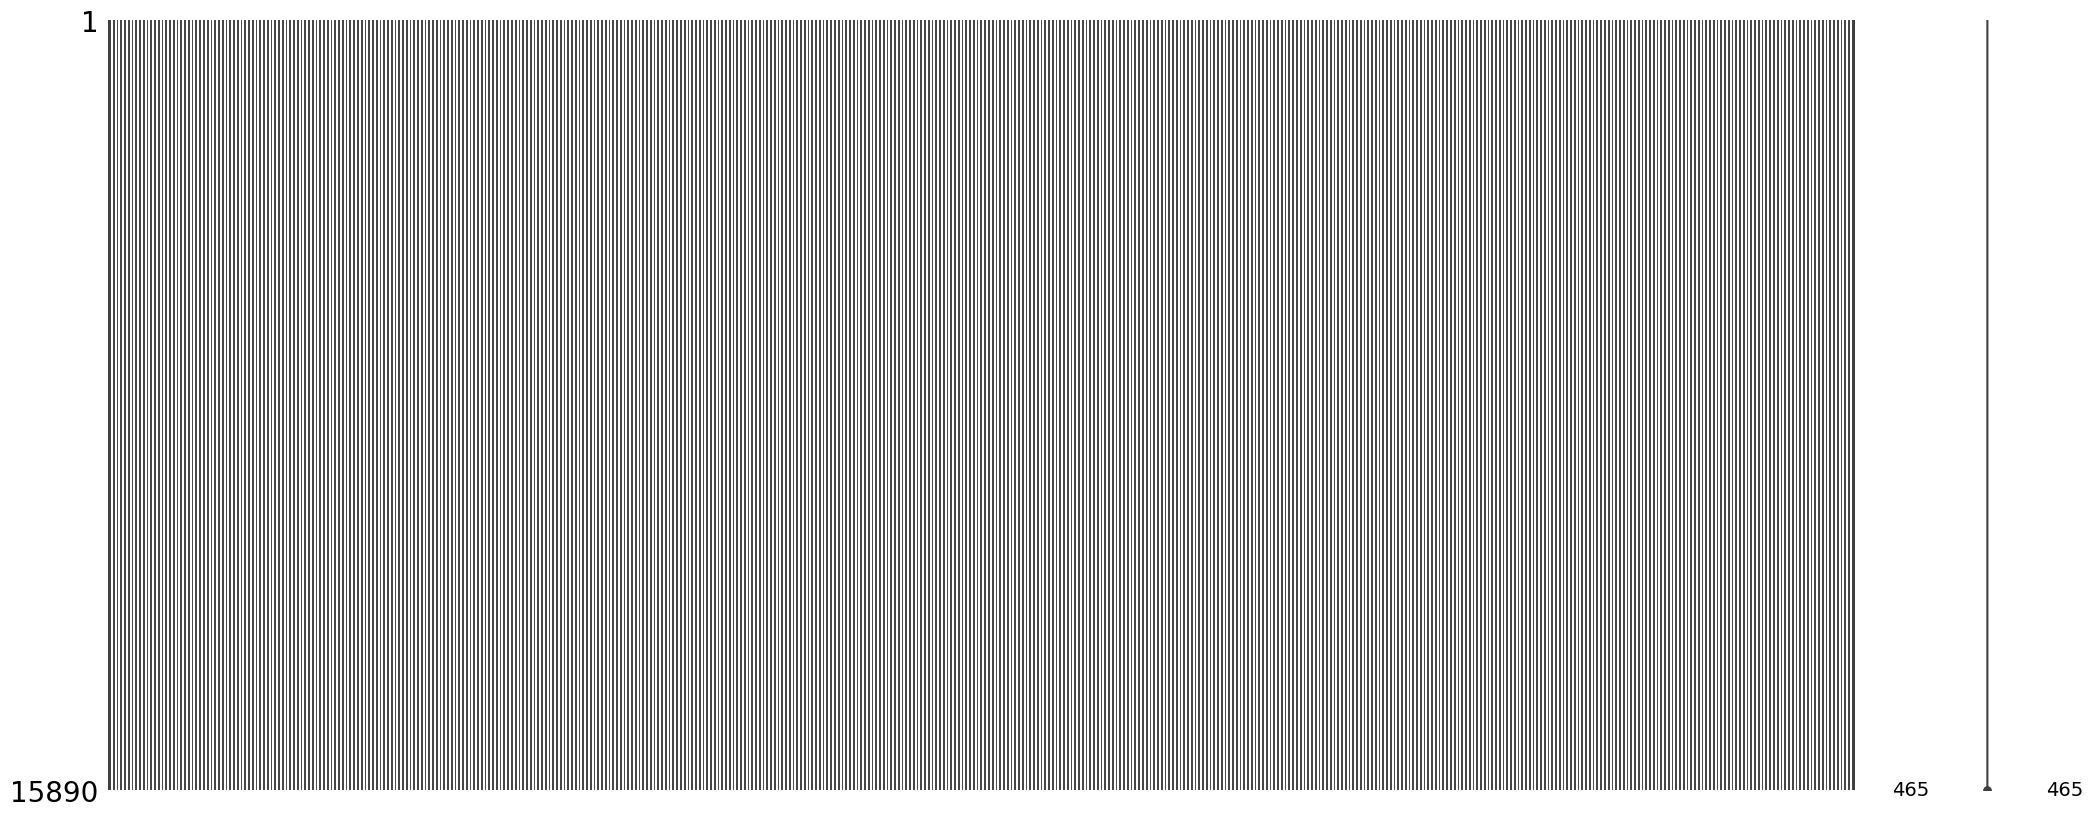

<Figure size 1000x500 with 0 Axes>

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

# 데이터프레임 df에서 결측치 시각화
msno.matrix(df)
plt.figure(figsize=(10, 5))  
plt.show()

In [6]:
import random
import os
import pandas as pd 
import numpy as np
from tqdm.auto import tqdm
from sklearn.preprocessing import LabelEncoder

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

CFG = {
    'TRAIN_WINDOW_SIZE':90, # 90일치로 학습
    'PREDICT_SIZE':21, # 21일치 예측
    'EPOCHS':10, # 반복
    'LEARNING_RATE':1e-4,
    'BATCH_SIZE':1096, # 데이터 묶음
    'SEED':41
}


무작위성을 제어하기 위해 여러 라이브러리의 시드(seed)를 설정하는 함수를 정의하고, 해당 시드로 무작위성을 고정시키는 코드입니다. 이를 통해 코드 실행 시마다 동일한 결과를 얻을 수 있습니다. 이러한 작업은 실험 재현성을 위해 중요합니다.

여기서 사용된 함수와 해당 함수 내용에 대한 설명은 다음과 같습니다:

1. **seed_everything(seed)**: 이 함수는 시드(seed)를 입력으로 받아서 여러 라이브러리의 시드를 설정하는 역할을 합니다. 이 함수를 호출하여 시드를 설정하면 코드 실행 시의 난수 생성이 일관된 결과를 보이게 됩니다.

2. **random.seed(seed)**: 파이썬의 기본 랜덤 모듈인 `random`의 시드를 설정합니다. 이로써 파이썬의 내장 랜덤 함수가 동일한 순서로 결과를 생성하게 됩니다.

3. **os.environ['PYTHONHASHSEED'] = str(seed)**: 파이썬 내장 해시 함수와 관련된 시드를 설정합니다. 해시 함수에도 시드를 적용하여 해시 값의 순서를 일관성 있게 만듭니다.

4. **np.random.seed(seed)**: NumPy의 난수 생성 함수의 시드를 설정합니다. NumPy를 사용하는 랜덤 연산에도 시드가 영향을 줍니다.

5. **torch.manual_seed(seed)**: PyTorch의 난수 생성 함수의 시드를 설정합니다. 파이토치 내에서의 랜덤성에 영향을 미칩니다.

6. **torch.cuda.manual_seed(seed)**: CUDA(GPU)를 사용하는 경우, 해당 GPU의 난수 생성 함수의 시드를 설정합니다.

7. **torch.backends.cudnn.deterministic = True**: CUDA 연산을 위한 cuDNN 라이브러리에서 무작위성을 완전히 제거하여, 동일한 입력에 대해 동일한 결과를 보장합니다. 단, 이로 인해 일부 성능 저하가 발생할 수 있습니다.

8. **torch.backends.cudnn.benchmark = True**: cuDNN 라이브러리의 동적 벤치마크 모드를 활성화합니다. 이 모드에서는 입력 크기에 따라 최적의 연산을 선택하여 속도를 높일 수 있지만, 일관된 결과를 보장하지 않습니다. 실험 재현성을 위해서는 비활성화하는 것이 좋습니다.

마지막으로 `seed_everything(CFG['SEED'])`라인은 코드의 `CFG` 딕셔너리에서 `'SEED'` 키에 저장된 시드 값을 가져와서 위에서 정의한 함수를 통해 무작위성을 고정시키는 역할을 합니다. 이를 통해 동일한 시드로 코드를 실행하면 항상 동일한 결과를 얻을 수 있습니다.

In [7]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG['SEED']) # Seed 고정

## MinMax Scaling
- 데이터를 정해진 범위 내로 변환하는 데이터 스케일링 기법 중 하나입니다. 주어진 데이터의 최솟값과 최댓값을 사용하여 데이터를 새로운 범위로 변환하므로, 모든 데이터가 일정한 범위 내에 들도록 조정됩니다.
- 이러한 스케일링은 다양한 머신러닝 알고리즘에서 데이터의 분포를 조정하거나, 특정 feature의 영향력을 균등하게 만들기 위해 사용됩니다.

MinMax Scaling의 수식은 다음과 같습니다:

$$
X_{\text{new}} = \frac{X - X_{\text{min}}}{X_{\text{max}} - X_{\text{min}}}
$$

여기서,
- $X_{\text{new}}$는 스케일링된 새로운 값
- $X$는 원본 데이터 값
- $X_{\text{min}}$은 해당 feature의 최솟값
- $X_{\text{max}}$은 해당 feature의 최댓값

이렇게 스케일링을 수행하면 모든 데이터는 0과 1 사이의 범위에 위치하게 됩니다. 하지만 주의할 점은 MinMax Scaling은 이상치(outliers)에 민감할 수 있어서 이상치가 있는 데이터에서는 오히려 스케일링 결과가 왜곡될 수 있습니다.

Min-Max Scaling은 정해진 범위 내에서 데이터를 조정할 수 있으므로, 다양한 데이터를 일정한 범위로 조정하여 학습 알고리즘의 성능을 개선하거나 특정 feature의 영향을 균등하게 만드는 데 사용됩니다.

숫자형 변수들을 min-max scaling으로 스케일링하는 작업을 수행하는 코드입니다. 이 코드를 통해 데이터의 값을 일정 범위로 조정하여 모델 학습을 개선하거나, 데이터의 분포를 조절하는 등의 효과를 얻을 수 있습니다.

아래는 코드의 각 부분에 대한 설명입니다:

1. **numeric_cols = train_data.columns[4:]**: `train_data`의 열 중 4번 인덱스부터 끝까지가 숫자형 변수임을 가정하고 해당 열들을 `numeric_cols`에 할당합니다.

2. **min_values = train_data[numeric_cols].min(axis=1)**: 각 행별로 숫자형 변수들의 최소값을 계산하여 `min_values`에 저장합니다.

3. **max_values = train_data[numeric_cols].max(axis=1)**: 각 행별로 숫자형 변수들의 최대값을 계산하여 `max_values`에 저장합니다.

4. **ranges = max_values - min_values**: 각 행별로 변수들의 범위를 계산합니다.

5. **ranges[ranges == 0] = 1**: 범위가 0인 경우, 1로 대체하여 나누기 연산 시 분모가 0이 되는 것을 방지합니다. 이는 값들이 동일한 경우에 해당합니다.

6. **train_data[numeric_cols] = ...**: 데이터프레임 `train_data`의 숫자형 변수들에 대해 min-max scaling을 수행합니다. 각 변수의 값에서 최소값을 뺀 후, 계산한 범위로 나눠서 값을 0과 1 사이의 범위로 조정합니다.

7. **scale_min_dict = min_values.to_dict()** 및 **scale_max_dict = max_values.to_dict()**: min-max scaling에 사용된 각 변수의 최소값과 최대값을 각각 딕셔너리 형태로 저장합니다. 이후에 테스트 데이터나 새로운 데이터를 스케일링할 때 사용할 수 있습니다.

이 코드는 데이터의 값을 일정 범위로 조정하여 모델 학습에 도움이 될 수 있으며, 스케일링된 데이터와 관련된 정보를 저장하여 추후에 재사용할 수 있도록 합니다.

In [8]:
train_data = pd.read_csv('./train.csv').drop(columns=['ID', '제품'])

# Data Scaling
# 숫자형 변수들의 min-max scaling을 수행하는 코드입니다.
numeric_cols = train_data.columns[4:]
# 칵 column의 min 및 max 계산
min_values = train_data[numeric_cols].min(axis=1)
max_values = train_data[numeric_cols].max(axis=1)
# 각 행의 범위(max-min)를 계산하고, 범위가 0인 경우 1로 대체
ranges = max_values - min_values
ranges[ranges == 0] = 1
# min-max scaling 수행
train_data[numeric_cols] = (train_data[numeric_cols].subtract(min_values, axis=0)).div(ranges, axis=0)
# max와 min 값을 dictionary 형태로 저장
scale_min_dict = min_values.to_dict()
scale_max_dict = max_values.to_dict()

# Label Encoding
label_encoder = LabelEncoder()
categorical_columns = ['대분류', '중분류', '소분류', '브랜드']

for col in categorical_columns:
    label_encoder.fit(train_data[col])
    train_data[col] = label_encoder.transform(train_data[col])

### 1. **`make_train_data(data, train_size, predict_size)`**:
   - 주어진 시계열 데이터(`data`)로부터 학습용 데이터와 레이블을 생성하는 함수입니다.
   - `train_size`: 학습에 사용할 시계열 데이터의 기간
   - `predict_size`: 추론에 사용할 시계열 데이터의 기간
   - 함수 내부에서는 `data`의 각 행을 순회하며 데이터를 추출합니다.
   - 추출한 데이터는 입력 데이터(input_data)와 레이블(target_data)로 구성됩니다.
   - `input_data`는 학습 데이터의 윈도우 내에서 판매량과 관련된 피처를 포함합니다. 윈도우 내에서의 판매량 이전에 있는 데이터도 인코딩 정보와 함께 입력 데이터로 사용됩니다.
   - `target_data`는 추론할 기간의 판매량을 나타냅니다.

### 2. **`make_predict_data(data, train_size)`**:
   - 주어진 시계열 데이터(`data`)로부터 추론용 데이터를 생성하는 함수입니다.
   - `train_size`: 추론을 위해 필요한 일별 판매량 기간 (= 학습에 활용할 기간)
   - 함수 내부에서는 `data`의 각 행을 순회하며 데이터를 추출합니다.
   - 추출한 데이터는 추론용 입력 데이터(input_data)로 구성됩니다.
   - `input_data`는 추론을 위한 입력 데이터로, 인코딩 정보와 윈도우 내의 판매량을 포함합니다.

In [9]:
def make_train_data(data, train_size=CFG['TRAIN_WINDOW_SIZE'], predict_size=CFG['PREDICT_SIZE']):
    '''
    학습 기간 블럭, 예측 기간 블럭의 세트로 데이터를 생성
    data : 일별 판매량
    train_size : 학습에 활용할 기간
    predict_size : 추론할 기간
    '''
  
    STEP_SIZE = 5 # 이 값을 본인의 환경에 맞게 조정
    
    
    num_rows = len(data)
    window_size = train_size + predict_size
    adjusted_size = (len(data.columns) - window_size + 1) // STEP_SIZE

    input_data = np.empty((num_rows * adjusted_size, train_size, len(data.iloc[0, :4]) + 1))
    target_data = np.empty((num_rows * adjusted_size, predict_size))

    for i in tqdm(range(num_rows)):
        encode_info = np.array(data.iloc[i, :4])
        sales_data = np.array(data.iloc[i, 4:])

        for j in range(0, len(sales_data) - window_size + 1, STEP_SIZE):
            window = sales_data[j: j + window_size]
            temp_data = np.column_stack((np.tile(encode_info, (train_size, 1)), window[:train_size]))
            input_data[i * adjusted_size + j // STEP_SIZE] = temp_data
            target_data[i * adjusted_size + j // STEP_SIZE] = window[train_size:]
            
    return input_data, target_data

In [10]:
def make_predict_data(data, train_size=CFG['TRAIN_WINDOW_SIZE']):
    '''
    평가 데이터(Test Dataset)를 추론하기 위한 Input 데이터를 생성
    data : 일별 판매량
    train_size : 추론을 위해 필요한 일별 판매량 기간 (= 학습에 활용할 기간)
    '''
    num_rows = len(data)
    input_data = np.empty((num_rows, train_size, len(data.iloc[0, :4]) + 1))
    
    STEP_SIZE = 5  
    
    for i in tqdm(range(num_rows)):
        encode_info = np.array(data.iloc[i, :4])
        sales_data = np.array(data.iloc[i, -train_size:])
        
        for j in range(0, len(sales_data) - train_size + 1, STEP_SIZE):
            window = sales_data[j : j + train_size]
            temp_data = np.column_stack((np.tile(encode_info, (train_size, 1)), window))
            input_data[i * (len(sales_data) - train_size + 1) // STEP_SIZE + j // STEP_SIZE] = temp_data
    
    return input_data


In [11]:
import time
start = time.time()

train_input, train_target = make_train_data(train_data)
test_input = make_predict_data(train_data)

end = time.time()
print(end - start)

  0%|          | 0/15890 [00:00<?, ?it/s]

  0%|          | 0/15890 [00:00<?, ?it/s]

75.58224129676819


In [12]:
# Train / Validation Split
data_len = len(train_input)
val_input = train_input[-int(data_len*0.2):]
val_target = train_target[-int(data_len*0.2):]
train_input = train_input[:-int(data_len*0.2)]
train_target = train_target[:-int(data_len*0.2)]

train_input.shape, train_target.shape, val_input.shape, val_target.shape, test_input.shape

((889840, 90, 5), (889840, 21), (222460, 90, 5), (222460, 21), (15890, 90, 5))

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
        
    def __getitem__(self, index):
        if self.Y is not None:
            return torch.Tensor(self.X[index]), torch.Tensor(self.Y[index])
        return torch.Tensor(self.X[index])
    
    def __len__(self):
        return len(self.X)
    
train_dataset = CustomDataset(train_input, train_target)
train_loader = DataLoader(train_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=True, num_workers=0)

val_dataset = CustomDataset(val_input, val_target)
val_loader = DataLoader(val_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

class BaseModel(nn.Module):
    def __init__(self, input_size=5, hidden_size=512, output_size=CFG['PREDICT_SIZE']):
        super(BaseModel, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, hidden_size//2),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(hidden_size//2, output_size)
        )
            
        self.actv = nn.ReLU()
    
    def forward(self, x):
        # x shape: (B, TRAIN_WINDOW_SIZE, 5)
        batch_size = x.size(0)
        hidden = self.init_hidden(batch_size, x.device)
        
        # LSTM layer
        lstm_out, hidden = self.lstm(x, hidden)
        
        # Only use the last output sequence
        last_output = lstm_out[:, -1, :]
        
        # Fully connected layer
        output = self.actv(self.fc(last_output))
        
        return output.squeeze(1)
    
    def init_hidden(self, batch_size, device):
        # Initialize hidden state and cell state
        return (torch.zeros(1, batch_size, self.hidden_size, device=device),
                torch.zeros(1, batch_size, self.hidden_size, device=device))
    
def train(model, optimizer, train_loader, val_loader, device):
    model.to(device)
    criterion = nn.MSELoss().to(device)
    best_loss = 9999999
    best_model = None
    
    for epoch in range(1, CFG['EPOCHS']+1):
        model.train()
        train_loss = []
        train_mae = []
        for X, Y in tqdm(iter(train_loader)):
            X = X.to(device)
            Y = Y.to(device)
            
            optimizer.zero_grad()
            
            output = model(X)
            loss = criterion(output, Y)
            
            loss.backward()
            optimizer.step()
            
            train_loss.append(loss.item())
        
        val_loss = validation(model, val_loader, criterion, device)
        print(f'Epoch : [{epoch}] Train Loss : [{np.mean(train_loss):.5f}] Val Loss : [{val_loss:.5f}]')
        
        if best_loss > val_loss:
            best_loss = val_loss
            best_model = model
            print('Model Saved')
    return best_model
def validation(model, val_loader, criterion, device):
    model.eval()
    val_loss = []
    
    with torch.no_grad():
        for X, Y in tqdm(iter(val_loader)):
            X = X.to(device)
            Y = Y.to(device)
            
            output = model(X)
            loss = criterion(output, Y)
            
            val_loss.append(loss.item())
    return np.mean(val_loss)
model = BaseModel()
optimizer = torch.optim.Adam(params = model.parameters(), lr = CFG["LEARNING_RATE"])
infer_model = train(model, optimizer, train_loader, val_loader, device)

  0%|          | 0/812 [00:00<?, ?it/s]